In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:


class Point:
    def __init__(self, x=0, y=0):    
        x = x
        y = x


num_lines = 768
line_length = 0.12
angle = 0.04
tan_angle = np.tan(angle)


vertical_lines = np.zeros(num_lines)
for i in range(num_lines):
    vertical_lines[i] = i * line_length / (num_lines - 1)

# Define the rotated lines (assuming y-intercepts evenly spaced)
rotated_lines = np.zeros(num_lines)
for j in range(num_lines):
    rotated_lines[j] = j * line_length / (num_lines - 1) # Evenly spaced between 0 and 12 cm

# Calculate the intersection points
intersection_points = []
for c_i in vertical_lines:
    for b_j in rotated_lines:
        intersection = Point()
        intersection.x = c_i
        intersection.y = tan_angle * c_i + b_j
        intersection_points.append(intersection)

# Print the intersection points
# for point in intersection_points:
#     print("Intersection at (", point.x, ", ", point.y, ")")



In [3]:


# # Define parameters
# num_lines = 100
# line_length = 0.12  # 12 cm
# angle = 0.04  # 40 mrad in radians
# tan_angle = np.tan(angle)

# # Define the vertical lines
# x_vertical = np.linspace(0, line_length, num_lines)

# # Define the rotated lines
# y_intercepts = np.linspace(0, line_length, num_lines)

# # Create figure and axis
# fig, ax = plt.subplots()

# # Plot vertical lines
# for x in x_vertical:
#     ax.plot([0, line_length], [x, x], 'b', linewidth=0.1)  # 'b' for blue

# # Plot rotated lines (almost vertical)
# for i, b in enumerate(y_intercepts):
#     x_vals = np.array([0, line_length])
#     y_vals = tan_angle * (x_vals - 0.06) + b  # Shift by 0.06 to ensure full overlap
    
#     if i % 10 ==0 :
#         ax.plot(x_vals, y_vals, 'r', linewidth=0.1)  # 'r' for red
    
    

# # Calculate and plot intersection points
# intersection_points_x = []
# intersection_points_y = []

# for x in x_vertical:
#     for b in y_intercepts:
#         y = tan_angle * (x - 0.06) + b  # Adjust for the shift
#         intersection_points_x.append(x)
#         intersection_points_y.append(y)

# # ax.scatter(intersection_points_x, intersection_points_y, color='green')

# # Set plot limits
# ax.set_xlim(0, line_length)
# ax.set_ylim(0, line_length)

# # Labels and title
# ax.set_xlabel('X axis')
# ax.set_ylabel('Y axis')
# ax.set_title('Intersection Points of Vertical and Rotated Lines')

# # Show plot
# plt.show()


In [3]:
def DoRotation(xspan, yspan, RotRad=0):
    """Generate a meshgrid and rotate it by RotRad radians."""

    # Clockwise, 2D rotation matrix
    RotMatrix = np.array([[np.cos(RotRad),  np.sin(RotRad)],
                          [-np.sin(RotRad), np.cos(RotRad)]])

    x, y = np.meshgrid(xspan, yspan)
    return np.einsum('ji, mni -> jmn', RotMatrix, np.dstack([x, y]))

In [4]:
def get_line_params(xvals, yvals):
    dx = xvals[-1] - xvals[0]
    dy = yvals[-1] - yvals[0]
    
    if dx != 0 and dy != 0: # Regular line
        a = - dy / dx
        b = 1
        c = (yvals[0] + a * xvals[0])
        return a, b, c
    
    elif dx == 0:  # Vertical line x = c
        a = 1
        b = 0
        c = -xvals[0]
        return a, b, c
        
    elif dy == 0:   # Horizontal line y = c
        a = 0
        b = 1
        c = -yvals[0]
        return a, b, c


In [6]:
# x = np.linspace(-3, 3, 769)
# y = np.linspace(-6, 6, 769)

# # coords_top = np.meshgrid(x, y)
# coords_top = DoRotation(x, y, 0)
# coords_bottom = DoRotation(x, y, 0.04)

# top_line_params = [get_line_params(coords_top[0].T[i], coords_top[1].T[i]) for i in range(0, len(coords_top[0]))]
# bottom_line_params = [get_line_params(coords_bottom[0].T[i], coords_bottom[1].T[i]) for i in range(0, len(coords_bottom[1]))]

# x_intersection_points = []
# y_intersection_points = []

# for line1 in top_line_params:
#     a1, b1, c1 = line1
#     for line2 in bottom_line_params:
#         a2, b2, c2 = line2
        
#         x_intercept = (b1*c2 - b2*c1) / (a1*b2 - a2*b1)
#         y_intercept = (c1*a2 - c2*a1) / (a1*b2 - a2*b1)
        
#         if abs(x_intercept) <= 3 and abs(y_intercept) <= 6:
#             x_intersection_points.append(x_intercept)
#             y_intersection_points.append(y_intercept)
        
#             # print(x_intercept, y_intercept)
        
# plt.scatter(x_intersection_points, y_intersection_points, color='red', s=0.1)
# plt.plot(coords_top[0], coords_top[1], color='blue', linewidth=0.1)
# plt.plot(coords_bottom[0], coords_bottom[1], color='orange', linewidth=0.1)
# plt.xlim(-3.5, 3.5)
# plt.ylim(-6.5, 6.5)

# plt.savefig("test-vert.pdf")

In [5]:
def rotate_point(px, py, cx, cy, angle):
    s = np.sin(angle)
    c = np.cos(angle)
    px -= cx
    py -= cy
    xnew = px * c - py * s
    ynew = px * s + py * c
    px = xnew + cx
    py = ynew + cy
    return px, py

def point_in_rectangle(px, py, rect):
    rx_min, rx_max = min(rect[:, 0]), max(rect[:, 0])
    ry_min, ry_max = min(rect[:, 1]), max(rect[:, 1])
    return rx_min < px < rx_max and ry_min < py < ry_max


def check_overlap(length, width, angle1, angle2, point):
    # Define the vertices of the base rectangle (centered at origin, for example)
    rect1 = np.array([[-length, -width], [length, -width], [length, width], [-length, width]])

    # Define the center
    center = (0, 0)
    
    # Apply rotation to the vertices of the second rectangle
    rect2 = np.array([rotate_point(x, y, *center, angle2) for x, y in rect1])
    rect3 = np.array([rotate_point(x, y, *center, angle1) for x, y in rect1])

    rot_point = rotate_point(point[0], point[1], *center, angle2)
    
    # Check if the point is within both rectangles
    inside_rect2 = point_in_rectangle(point[0], point[1], rect3)
    inside_rect3 = point_in_rectangle(rot_point[0], rot_point[1], rect1)

    # Determine if the point is in the overlapping area
    in_overlap = inside_rect2 and inside_rect3
    
    return in_overlap


In [8]:
# x = np.linspace(-3, 3, 769)
# y = np.linspace(-6, 6, 769)

# # coords_top = np.meshgrid(x, y)
# coords_top = DoRotation(x, y, np.pi/2)
# coords_bottom = DoRotation(x, y, np.pi/2+0.04)

# top_line_params = [get_line_params(coords_top[0].T[i], coords_top[1].T[i]) for i in range(0, len(coords_top[0]))]
# bottom_line_params = [get_line_params(coords_bottom[0].T[i], coords_bottom[1].T[i]) for i in range(0, len(coords_bottom[1]))]

# x_intersection_points = []
# y_intersection_points = []

# for line1 in top_line_params:
#     a1, b1, c1 = line1
#     for line2 in bottom_line_params:
#         a2, b2, c2 = line2
        
#         x_intercept = (b1*c2 - b2*c1) / (a1*b2 - a2*b1)
#         y_intercept = (c1*a2 - c2*a1) / (a1*b2 - a2*b1)
       
#         if check_overlap(3, 6, np.pi/2, np.pi/2+0.04, (x_intercept, y_intercept)):
#             x_intersection_points.append(x_intercept)
#             y_intersection_points.append(y_intercept)
 
                
# plt.scatter(x_intersection_points, y_intersection_points, color='red', s=0.1)
# plt.plot(coords_top[0], coords_top[1], color='blue', linewidth=0.1)
# plt.plot(coords_bottom[0], coords_bottom[1], color='orange', linewidth=0.1)
# plt.ylim(-3.5, 3.5)
# plt.xlim(-6.5, 6.5)

# plt.savefig("test-horiz.pdf")


In [6]:
def rotate_coordinates(coords, theta):
    """
    Rotate a set of 2D coordinates by theta radians.

    Args:
        coords: A NumPy array of shape (n, 2) where n is the number of coordinates.
        theta: The rotation angle in radians.

    Returns:
        A NumPy array of the rotated coordinates.
    """
    # Define the rotation matrix
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    # Apply the rotation matrix to the coordinates
    rotated_coords = np.dot(coords, rotation_matrix)
    return rotated_coords

In [7]:
def get_line_params(xvals, yvals):
    # ax + by + c = 0
    dx = np.amax(xvals) - np.amin(xvals)
    dy = np.amax(yvals) - np.amin(yvals)
    
    if dx != 0 and dy != 0: # Regular line
        a = - dy / dx
        b = 1
        c = (yvals[0] + a * xvals[0])
        return a, b, c
    
    elif dx == 0:  # Vertical line x = - c / a
        a = 1
        b = 0
        c = -xvals[0]
        return a, b, c
        
    elif dy == 0:   # Horizontal line y = -c / b
        a = 0
        b = 1
        c = -yvals[0]
        return a, b, c


In [8]:

def rotate_line(a, b, c, theta):
    # Calculate the cos and sin of the rotation angle
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    # New coefficients after rotation
    a_prime = a * cos_theta + b * sin_theta
    b_prime = b * cos_theta - a * sin_theta
    

    return a_prime, b_prime, c


In [9]:
def point_to_line_distance(a, b, c, x0, y0):
    return abs(a * x0 + b * y0 + c) / np.sqrt(a**2 + b**2)

In [10]:
def compute_intercept(a1, b1,c1, a2, b2, c2):
    x_intercept = (b1*c2 - b2*c1) / (a1*b2 - a2*b1)
    y_intercept = (c1*a2 - c2*a1) / (a1*b2 - a2*b1)
    
    return x_intercept, y_intercept

61.44 m


[[(1, 0, np.float64(8.027760416666666)), (1, 0, np.float64(7.945))], [(1, 0, np.float64(-28.635104166666665)), (1, 0, np.float64(-28.717864583333338))], [(1, 0, np.float64(-14.73135416666667)), (1, 0, np.float64(-14.814114583333335))], [(1, 0, np.float64(-6.20703125)), (1, 0, np.float64(-6.289791666666666))], [(1, 0, np.float64(21.93151041666667)), (1, 0, np.float64(21.848750000000003))], [(1, 0, np.float64(21.93151041666667)), (1, 0, np.float64(21.848750000000003))], [(1, 0, np.float64(28.13854166666667)), (1, 0, np.float64(28.055781250000003))], [(1, 0, np.float64(-23.25567708333333)), (1, 0, np.float64(-23.338437499999998))], [(1, 0, np.float64(-6.372552083333332)), (1, 0, np.float64(-6.455312499999998))], [(1, 0, np.float64(-13.158906250000001)), (1, 0, np.float64(-13.241666666666667))], [(1, 0, np.float64(30.53859375)), (1, 0, np.float64(30.455833333333334))], [(1, 0, np.float64(-29.793750000000003)), (1, 0, np.float64(-29.87651041666667))], [(1, 0, np.float64(-21.10390625)), (1, 

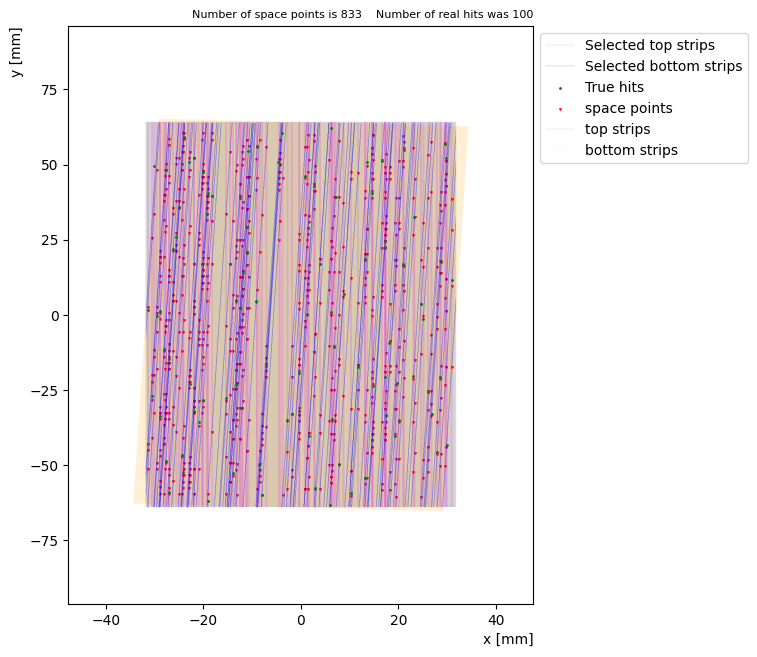

In [11]:
sct_width = 63.56
sct_length = 128.05
y = np.linspace(-sct_length/2, sct_length/2, 769)
x = np.linspace(-sct_width/2, sct_width/2, 769)

print(f"{80e-6 * 768 * 1000:.2f} m")

fig, ax = plt.subplots(figsize=(6, 7.5))

angle_top = 0
angle_bottom = 0.04

np.random.seed(42)
rpx = np.random.rand(100) * sct_width - sct_width/2
rpy = np.random.rand(100) * sct_length - sct_length/2


coords = []
for xx in x:
    tmp = np.array([[xx, sct_length/2], [xx, -sct_length/2]])
    coords.append(tmp)


coords_top = rotate_coordinates(coords, 0)
coords_bottom = rotate_coordinates(coords, 0.04)

top_line_params = [get_line_params(coords_top[i][:,0], coords_top[i][:,1]) for i in range(0, len(coords_top))]
bottom_line_params = [get_line_params(coords_bottom[i][:,0], coords_bottom[i][:,1]) for i in range(0, len(coords_bottom))]

hit_top_strips = []
hit_bottom_strips = []


for px, py in zip(rpx, rpy):
    distances = []
    for a, b, c in top_line_params: 
        distance_to_line = point_to_line_distance(a, b, c, px, py)
        distances.append(distance_to_line)
    
    sorted_indices = np.argsort(distances)
    closest_lines = sorted_indices[:2]
    closest_lines = sorted(closest_lines)
    
    hit_top_strips += [[top_line_params[l] for l in closest_lines]]
    
for px, py in zip(rpx, rpy):
    distances = []
    for a, b, c in bottom_line_params: 
        distance_to_line = point_to_line_distance(a, b, c, px, py)
        distances.append(distance_to_line)
    
    sorted_indices = np.argsort(distances)
    closest_lines = sorted_indices[:2]
    closest_lines = sorted(closest_lines)
    
    hit_bottom_strips += [[bottom_line_params[l] for l in closest_lines]]       


x_intersection_points = []
y_intersection_points = []

space_points_x = []
space_points_y = []

for (top1, top2) in hit_top_strips:
    a11, b11, c11 = top1
    a12, b12, c12 = top2
    for (bottom1, bottom2) in hit_bottom_strips:
    
        a21, b21, c21 = bottom1
        a22, b22, c22 = bottom2
            
        top1bottom1_intercept = compute_intercept(a11, b11, c11, a21, b21, c21)
        top1bottom2_intercept = compute_intercept(a11, b11, c11, a22, b22, c22)
        top2bottom1_intercept = compute_intercept(a12, b12, c12, a21, b21, c21)
        top2bottom2_intercept = compute_intercept(a12, b12, c12, a22, b22, c22)
        
        is_valid = True
        
        if check_overlap(sct_width/2, sct_length/2, 0, 0.04, (top1bottom1_intercept[0], top1bottom1_intercept[1])):
            x_intersection_points.append(top1bottom1_intercept[0])
            y_intersection_points.append(top1bottom1_intercept[1])
        else:
            is_valid = False
        
        if check_overlap(sct_width/2, sct_length/2, 0, 0.04, (top1bottom2_intercept[0], top1bottom2_intercept[1])):
            x_intersection_points.append(top1bottom2_intercept[0])
            y_intersection_points.append(top1bottom2_intercept[1])
        else:
            is_valid = False
        
        if check_overlap(sct_width/2, sct_length/2, 0, 0.04, (top2bottom1_intercept[0], top2bottom1_intercept[1])):
            x_intersection_points.append(top2bottom1_intercept[0])
            y_intersection_points.append(top2bottom1_intercept[1])
        else:
            is_valid = False
        
        if check_overlap(sct_width/2, sct_length/2, 0, 0.04, (top2bottom2_intercept[0], top2bottom2_intercept[1])):
            x_intersection_points.append(top2bottom2_intercept[0])
            y_intersection_points.append(top2bottom2_intercept[1])
        else:
            is_valid = False
        
        if is_valid:
            sp_x = (top1bottom1_intercept[0] + top1bottom2_intercept[0] + top2bottom1_intercept[0] + top2bottom2_intercept[0]) / 4
            sp_y = (top1bottom1_intercept[1] + top1bottom2_intercept[1] + top2bottom1_intercept[1] + top2bottom2_intercept[1]) / 4
            
            space_points_x.append(sp_x)
            space_points_y.append(sp_y)

print(hit_top_strips)
for pair in hit_top_strips:
    for (a, b, c) in pair:
        ax.plot(0*x- c, y, color='magenta', linewidth=0.1, zorder=9, label="Selected top strips")

for pair in hit_bottom_strips:
    for (a, b, c) in pair:
        yp = []
        xp = []
        
        for xx in np.linspace(-sct_width/2, sct_width/2, 5000):
            p = (-a/b)*xx - c/b
            if abs(p) <= sct_length/2:
                xp.append(xx)
                yp.append(p)
                
        ax.plot(xp, yp, color='blue', linewidth=0.1, zorder=9, label="Selected bottom strips")
        
ax.scatter(rpx, rpy, color='green', s=1, zorder=9, label='True hits')
# ax.scatter(x_intersection_points, y_intersection_points, color='red', s=0.5, alpha=0.5, marker='v')
ax.scatter(space_points_x, space_points_y, color='red', s=1,  marker='v', label='space points')
# print(f"Number of space points is {len(space_points_x)}    Number of real hits was {len(rpx)}")

# ax.scatter(space_points_x, space_points_y, color='red', s=1, alpha=1)

for i in range(len(coords_top)):
    ax.plot(coords_top[i][:,0], coords_top[i][:,1], color='black', linewidth=0.1, alpha=0.5, zorder=0, label='top strips')
for i in range(len(coords_top)):
    ax.plot(coords_bottom[i][:,0], coords_bottom[i][:,1], color='orange', linewidth=0.1, alpha=0.5, zorder=0, label='bottom strips')
ax.set_xlim(1.5 * -sct_width/2, 1.5 * sct_width/2)
ax.set_ylim(1.5 * -sct_length/2, 1.5 * sct_length/2)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title(f"Number of space points is {len(space_points_x)}    Number of real hits was {len(rpx)}", loc='right', fontsize=8)
ax.set_xlabel("x [mm]", loc='right')
ax.set_ylabel("y [mm]", loc='top')
plt.savefig("test-vert.pdf", bbox_inches='tight')

61.44 m
[[(0, 1, np.float64(29.793750000000003)), (0, 1, np.float64(29.710989583333333))], [(0, 1, np.float64(-8.607083333333335)), (0, 1, np.float64(-8.689843750000001))], [(0, 1, np.float64(11.834739583333334)), (0, 1, np.float64(11.751979166666668))], [(0, 1, np.float64(-0.4965625000000031)), (0, 1, np.float64(-0.5793229166666691))], [(0, 1, np.float64(-25.904010416666665)), (0, 1, np.float64(-25.98677083333333))], [(0, 1, np.float64(15.972760416666667)), (0, 1, np.float64(15.89))], [(0, 1, np.float64(5.71046875)), (0, 1, np.float64(5.627708333333334))], [(0, 1, np.float64(-16.221041666666665)), (0, 1, np.float64(-16.30380208333333))], [(0, 1, np.float64(17.296927083333333)), (0, 1, np.float64(17.214166666666667))], [(0, 1, np.float64(26.897135416666668)), (0, 1, np.float64(26.814375000000002))], [(0, 1, np.float64(13.4071875)), (0, 1, np.float64(13.324427083333333))], [(0, 1, np.float64(21.60046875)), (0, 1, np.float64(21.517708333333335))], [(0, 1, np.float64(-27.3109375)), (0, 1,

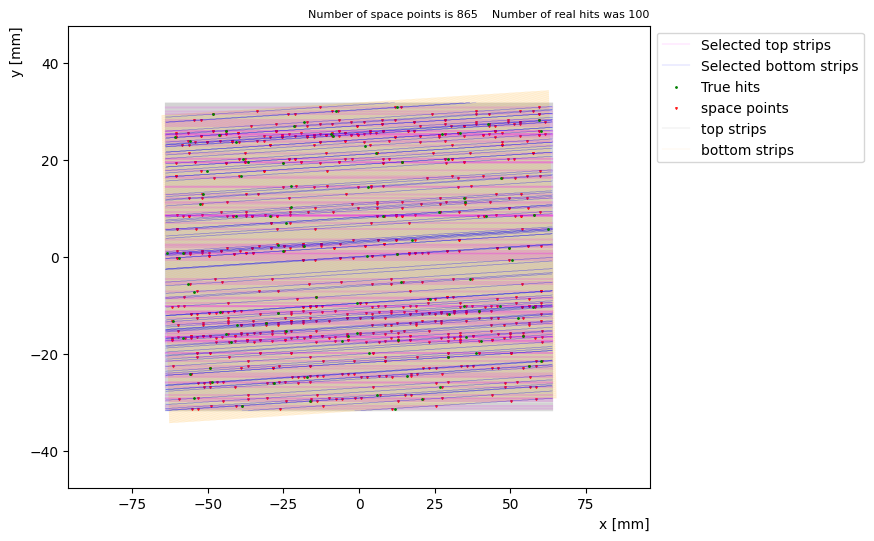

In [13]:
sct_width = 128.05
sct_length = 63.56
y = np.linspace(-sct_length/2, sct_length/2, 769)
x = np.linspace(-sct_width/2, sct_width/2, 769)

print(f"{80e-6 * 768 * 1000:.2f} m")

fig, ax = plt.subplots(figsize=(7.5, 6))

angle_top = 0 # np.pi/2
angle_bottom = -0.04#np.pi/2 + 0.04

np.random.seed(42)
rpx = np.random.rand(100) * sct_width - sct_width/2
rpy = np.random.rand(100) * sct_length - sct_length/2


coords = []
for yy in y:
    tmp = np.array([[sct_width/2, yy], [-sct_width/2, yy]])
    coords.append(tmp)


coords_top = rotate_coordinates(coords, angle_top)
coords_bottom = rotate_coordinates(coords, angle_bottom)

top_line_params = [get_line_params(coords_top[i][:,0], coords_top[i][:,1]) for i in range(0, len(coords_top))]
bottom_line_params = [get_line_params(coords_bottom[i][:,0], coords_bottom[i][:,1]) for i in range(0, len(coords_bottom))]

hit_top_strips = []
hit_bottom_strips = []


for px, py in zip(rpx, rpy):
    distances = []
    for a, b, c in top_line_params: 
        distance_to_line = point_to_line_distance(a, b, c, px, py)
        distances.append(distance_to_line)
    
    sorted_indices = np.argsort(distances)
    closest_lines = sorted_indices[:2]
    closest_lines = sorted(closest_lines)
    
    hit_top_strips += [[top_line_params[l] for l in closest_lines]]
    
for px, py in zip(rpx, rpy):
    distances = []
    for a, b, c in bottom_line_params: 
        distance_to_line = point_to_line_distance(a, b, c, px, py)
        distances.append(distance_to_line)
    
    sorted_indices = np.argsort(distances)
    closest_lines = sorted_indices[:2]
    closest_lines = sorted(closest_lines)
    
    hit_bottom_strips += [[bottom_line_params[l] for l in closest_lines]]       


x_intersection_points = []
y_intersection_points = []

space_points_x = []
space_points_y = []

for (top1, top2) in hit_top_strips:
    a11, b11, c11 = top1
    a12, b12, c12 = top2
    for (bottom1, bottom2) in hit_bottom_strips:
    
        a21, b21, c21 = bottom1
        a22, b22, c22 = bottom2
            
        top1bottom1_intercept = compute_intercept(a11, b11, c11, a21, b21, c21)
        top1bottom2_intercept = compute_intercept(a11, b11, c11, a22, b22, c22)
        top2bottom1_intercept = compute_intercept(a12, b12, c12, a21, b21, c21)
        top2bottom2_intercept = compute_intercept(a12, b12, c12, a22, b22, c22)
        
        is_valid = True
        
        if check_overlap(sct_width/2, sct_length/2, angle_bottom, angle_top, (top1bottom1_intercept[0], top1bottom1_intercept[1])):
            x_intersection_points.append(top1bottom1_intercept[0])
            y_intersection_points.append(top1bottom1_intercept[1])
        else:
            is_valid = False
        
        if check_overlap(sct_width/2, sct_length/2, angle_bottom, angle_top, (top1bottom2_intercept[0], top1bottom2_intercept[1])):
            x_intersection_points.append(top1bottom2_intercept[0])
            y_intersection_points.append(top1bottom2_intercept[1])
        else:
            is_valid = False
        
        if check_overlap(sct_width/2, sct_length/2, angle_bottom, angle_top, (top2bottom1_intercept[0], top2bottom1_intercept[1])):
            x_intersection_points.append(top2bottom1_intercept[0])
            y_intersection_points.append(top2bottom1_intercept[1])
        else:
            is_valid = False
        
        if check_overlap(sct_width/2, sct_length/2, angle_bottom, angle_top, (top2bottom2_intercept[0], top2bottom2_intercept[1])):
            x_intersection_points.append(top2bottom2_intercept[0])
            y_intersection_points.append(top2bottom2_intercept[1])
        else:
            is_valid = False
        
        if is_valid:
            sp_x = (top1bottom1_intercept[0] + top1bottom2_intercept[0] + top2bottom1_intercept[0] + top2bottom2_intercept[0]) / 4
            sp_y = (top1bottom1_intercept[1] + top1bottom2_intercept[1] + top2bottom1_intercept[1] + top2bottom2_intercept[1]) / 4
            
            space_points_x.append(sp_x)
            space_points_y.append(sp_y)

print(hit_top_strips)
for pair in hit_top_strips:
    for (a, b, c) in pair:
        ax.plot(x, 0*y- c, color='magenta', linewidth=0.1, zorder=9, label="Selected top strips")
        
for pair in hit_bottom_strips:
    for (a, b, c) in pair:
        yp = []
        xp = []
        
        # for xx in np.linspace(-sct_width/2, sct_width/2, 5000):
        #     p = (-a/b)*xx - c/b
        #     if abs(p) <= sct_width/2:
        #         xp.append(xx)
        #         yp.append(p)
        
        for yy in np.linspace(-sct_length/2, sct_length/2, 5000):
            p = (-b/a)*yy - c/a
            if abs(p) <= sct_width/2:
                xp.append(p)
                yp.append(yy)
        
        ax.plot(xp, yp, color='blue', linewidth=0.1, zorder=9, label="Selected bottom strips")
        
ax.scatter(rpx, rpy, color='green', s=1, zorder=9, label='True hits')
# ax.scatter(x_intersection_points, y_intersection_points, color='red', s=0.5, alpha=0.5, marker='v')
ax.scatter(space_points_x, space_points_y, color='red', s=1,  marker='v', label='space points')
# print(f"Number of space points is {len(space_points_x)}    Number of real hits was {len(rpx)}")

# ax.scatter(space_points_x, space_points_y, color='red', s=1, alpha=1)

for i in range(len(coords_top)):
    ax.plot(coords_top[i][:,0], coords_top[i][:,1], color='black', linewidth=0.1, alpha=0.5, zorder=0, label='top strips')
for i in range(len(coords_top)):
    ax.plot(coords_bottom[i][:,0], coords_bottom[i][:,1], color='orange', linewidth=0.1, alpha=0.5, zorder=0, label='bottom strips')

ax.set_xlim(1.5 * -sct_width/2, 1.5 * sct_width/2)
ax.set_ylim(1.5 * -sct_length/2, 1.5 * sct_length/2)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title(f"Number of space points is {len(space_points_x)}    Number of real hits was {len(rpx)}", loc='right', fontsize=8)
ax.set_xlabel("x [mm]", loc='right')
ax.set_ylabel("y [mm]", loc='top')
plt.savefig("test-horiz.pdf", bbox_inches='tight')

In [16]:
# x = np.linspace(-3, 3, 101)
# y = np.linspace(-6, 6, 101)
# angle_top = 0
# angle_bottom = 0.04

# np.random.seed(42)
# rpx = np.random.rand(1) * 6 - 3
# rpy = np.random.rand(1) * 12 - 6

# rand_point = (rpx, rpy)

# # coords_top = np.meshgrid(x, y)
# coords_top = DoRotation(x, y, angle_top)
# coords_bottom = DoRotation(x, y, angle_bottom)

# # top_line_params = [get_line_params(coords_top[0].T[i], coords_top[1].T[i]) for i in range(0, len(coords_top[0]))]
# # bottom_line_params = [get_line_params(coords_bottom[0].T[i], coords_bottom[1].T[i]) for i in range(0, len(coords_bottom[1]))]

# top_line_params = [get_line_params(coords_top[0][i], coords_top[1][i]) for i in range(0, len(coords_top[0]))]
# bottom_line_params = [get_line_params(coords_bottom[0][i], coords_bottom[1][i]) for i in range(0, len(coords_bottom[1]))]


# x_intersection_points = []
# y_intersection_points = []

# for line1 in top_line_params:
#     a1, b1, c1 = line1
#     for line2 in bottom_line_params:
#         a2, b2, c2 = line2
        
#         x_intercept = (b1*c2 - b2*c1) / (a1*b2 - a2*b1)
#         y_intercept = (c1*a2 - c2*a1) / (a1*b2 - a2*b1)
        
#         if check_overlap(3, 6, angle_top, angle_bottom, (x_intercept, y_intercept)):
#             x_intersection_points.append(x_intercept)
#             y_intersection_points.append(y_intercept)

# hit_top_strips = []
# hit_bottom_strips = []

# for px, py in zip(rpx, rpy):
#     low_dist = 1e6
#     high_dist = 1e6
#     low_strip = None
#     high_strip = None 
#     for i in range(0, len(top_line_params)):
#         # print(i, low_dist > abs(px - top_line_params[i][2]), low_dist, abs(px - top_line_params[i][2]), top_line_params[i][2], px)
#         if low_dist > abs(px - top_line_params[i][2]) and top_line_params[i][2] < px:
#             low_dist = abs(px - top_line_params[i][2])
#             low_strip =  top_line_params[i]
        
#         if high_dist > abs(px - top_line_params[i][2]) and top_line_params[i][2] > px:
#             high_dist = abs(px - top_line_params[i][2])
#             high_strip =  top_line_params[i]
        
#     if low_strip != None and high_strip != None:
#         hit_top_strips.append(low_strip)
#         hit_top_strips.append(high_strip)


# for px, py in zip(rpx, rpy):
#     low_dist = 1e6
#     high_dist = 1e6
#     low_strip = None
#     high_strip = None
#     px_rot, py_rot = rotate_point(px, py, 0, 0, angle_bottom) 
    
#     print(f"px_rot = {px_rot:.3f}")
    
#     for i in range(0, len(top_line_params)):
        
#         if low_dist > abs(px_rot - top_line_params[i][2]) and top_line_params[i][2] < px_rot:
#             low_dist = abs(px_rot - top_line_params[i][2])
#             low_strip =  top_line_params[i]
        
#         if high_dist > abs(px_rot - top_line_params[i][2]) and top_line_params[i][2] > px_rot:
#             high_dist = abs(px_rot - top_line_params[i][2])
#             high_strip =  top_line_params[i]
        
#     if low_strip != None and high_strip != None:
#         hit_bottom_strips.append(low_strip)
#         hit_bottom_strips.append(high_strip)
    

# fig, ax = plt.subplots(figsize=(6, 7.5))
# for (a, b, c) in hit_top_strips:
#     x_rot = coords_top[0].T[i]
#     y_rot = coords_top[1].T[i]
#     # print("\n", a,b,c)
#     ax.plot(np.ones_like(x) * c, y, color='purple', linewidth=0.5)

# for (a, b, c) in hit_bottom_strips:
#     x_rot = coords_top[0].T[i]
#     y_rot = coords_top[1].T[i]
    
#     ap, bp, cp = rotate_line(a,b,c, angle_bottom)
#     print("before - ", a, b, c)
#     print("after - ", ap, bp, cp)
#     # print(x, (-cp/bp)*x - cp/ap)
#     # print("\n")
    
#     ax.plot((-ap/bp)*y - cp/bp, y, color='brown', linewidth=0.5)
    
#     for i, xx in enumerate(x):
#         print((-bp/ap)*xx - cp/ap, y[i])
    
# ax.scatter(rpx, rpy, color='green', s=0.1)
# # ax.scatter(x_intersection_points, y_intersection_points, color='red', s=0.1)
# ax.plot(coords_top[0], coords_top[1], color='blue', linewidth=0.1)
# ax.plot(coords_bottom[0], coords_bottom[1], color='orange', linewidth=0.1)
# ax.set_xlim(-6, 6)
# ax.set_ylim(-7.5, 7.5)

# plt.savefig("test-vert-sp.pdf")